In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from models import LSTMNet
from load_data import loaddata
from train_utils import TrainModel

get data from folder

In [3]:
DATA_PATH = '../MP_Data'
X,Y ,map= loaddata(DATA_PATH)
print(map)     

(270, 30, 1662)
(270,)
{'thanks': 0, 'iloveyou': 1, 'hello': 2}


split and load data

In [12]:
#train_test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#set batch size while create dataloader
#train dataloader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#val dataloader
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

<h3>LSTM model

model instantiation & select device 

In [16]:
input_size = 1662
num_classes = len(map)
model_lstm = LSTMNet(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train the model

In [17]:
criterion = nn.CrossEntropyLoss()
#set learning rate
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.0001)
num_epochs = 50


train_lstm = TrainModel(model_lstm,device,criterion,optimizer)
trained_model_lstm, train_losses, train_accs, val_losses, val_accs = train_lstm.fit(num_epochs,train_loader,val_loader)

Start training!
Epoch: 10/50:Train loss: 0.829,Train acc: 0.653,Val loss: 0.575,Val acc.: 0.867
Epoch: 20/50:Train loss: 0.156,Train acc: 0.959,Val loss: 0.131,Val acc.: 0.967
Epoch: 30/50:Train loss: 0.212,Train acc: 0.947,Val loss: 0.077,Val acc.: 1.000
Epoch: 40/50:Train loss: 0.183,Train acc: 0.947,Val loss: 0.174,Val acc.: 0.925
Epoch: 50/50:Train loss: 0.031,Train acc: 0.995,Val loss: 0.018,Val acc.: 1.000


In [22]:
print(len(train_losses))
print(len(val_losses))

50
50


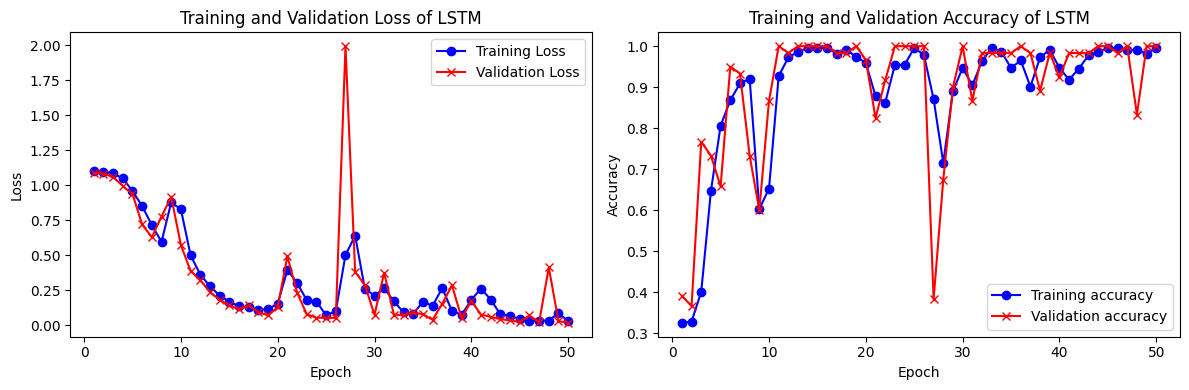

In [25]:
# YOUR CODE HERE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#Plot losses in training and validation
axes[0].plot((range(1, len(train_losses)+1)), train_losses, label='Training Loss', color='blue', marker = 'o')
axes[0].plot((range(1, len(val_losses)+1)), val_losses, label='Validation Loss', color='red', marker = 'x')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training and Validation Loss of LSTM')

#Plot accuracy
axes[1].plot((range(1, len(train_accs)+1)), train_accs, label='Training accuracy', color='blue', marker = 'o')
axes[1].plot((range(1, len(val_accs)+1)), val_accs, label='Validation accuracy', color='red', marker = 'x')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Training and Validation Accuracy of LSTM')

plt.tight_layout()
plt.show()